**Import necessary packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

Read the dataset

In [4]:
import pandas as pd
df=pd.read_csv("/content/Combined Data.csv",nrows=35000)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


Drop unnessary columns

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
34995,Health Anxiety causing physically visible symp...,Anxiety
34996,I found a bump on my arm and I’m panicking. I ...,Anxiety
34997,I need advice on what to do with my Enlarged S...,Anxiety
34998,New Here Unfortunately Hi all. I am new to thi...,Anxiety


In [6]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress'],
      dtype=object)

Select required records

***Data preprocessing and EDA***

Check the null values

In [7]:
df.isnull().sum()

,0
statement,10
status,0


Missing data handling

In [8]:
df['statement'].fillna(df['statement'].mode()[0], inplace=True)
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
34995,Health Anxiety causing physically visible symp...,Anxiety
34996,I found a bump on my arm and I’m panicking. I ...,Anxiety
34997,I need advice on what to do with my Enlarged S...,Anxiety
34998,New Here Unfortunately Hi all. I am new to thi...,Anxiety


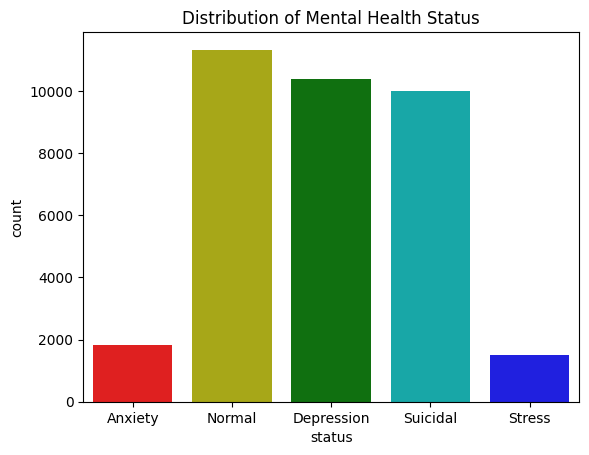

In [9]:
sns.countplot(x='status', data=df, palette=['r', 'y', 'g','c','b'])
plt.title('Distribution of Mental Health Status')
plt.show()


*Inference: The Normal category has the highest count , while anxiety and stress have the lowest.Since the dataset is imbalanced, a resambling technique is needed.*

Seperating text data

In [10]:
text=df.iloc[:,0]
text

,statement
0,oh my gosh
1,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ..."
3,I've shifted my focus to something else but I'...
4,"I'm restless and restless, it's been a month n..."
...,...
34995,Health Anxiety causing physically visible symp...
34996,I found a bump on my arm and I’m panicking. I ...
34997,I need advice on what to do with my Enlarged S...
34998,New Here Unfortunately Hi all. I am new to thi...


Removing special characters

In [11]:
text=text.str.replace('[^a-zA-Z0-9 ]',"",regex=True)
text

,statement
0,oh my gosh
1,trouble sleeping confused mind restless heart ...
2,All wrong back off dear forward doubt Stay in ...
3,Ive shifted my focus to something else but Im ...
4,Im restless and restless its been a month now ...
...,...
34995,Health Anxiety causing physically visible symp...
34996,I found a bump on my arm and Im panicking I ha...
34997,I need advice on what to do with my Enlarged S...
34998,New Here Unfortunately Hi all I am new to this...


In [12]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

converting text to lowercase and each words to its root word using stemming method

In [13]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()
text=text.apply(lambda row:[ps.stem(token.lower()) for token in nltk.word_tokenize(row)]).apply(lambda token:" ".join(token))
text

,statement
0,oh my gosh
1,troubl sleep confus mind restless heart all ou...
2,all wrong back off dear forward doubt stay in ...
3,ive shift my focu to someth els but im still w...
4,im restless and restless it been a month now b...
...,...
34995,health anxieti caus physic visibl symptom i re...
34996,i found a bump on my arm and im panick i have ...
34997,i need advic on what to do with my enlarg sple...
34998,new here unfortun hi all i am new to thi forum...


Removing stopwords

In [14]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw=stopwords.words('english')
print(sw)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
text=text.apply(lambda row:[token for token in nltk.word_tokenize(row) if token not in sw]).apply(lambda token:" ".join(token))
text.head()

,statement
0,oh gosh
1,troubl sleep confus mind restless heart tune
2,wrong back dear forward doubt stay restless re...
3,ive shift focu someth els im still worri
4,im restless restless month boy mean


Convert text to vectors using TFIDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector=TfidfVectorizer()
X=vector.fit_transform(text)
X


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1403788 stored elements and shape (35000, 48731)>

In [17]:
y=df['status'].map({'Anxiety':0,'Normal':1,'Depression':2,'Suicidal':3,'Stress':4})

In [18]:
y.unique()

array([0, 1, 2, 3, 4])

In [19]:
y.value_counts()

,count
status,
1,11324
2,10371
3,9993
0,1824
4,1488


Over sampling

In [20]:
from imblearn.over_sampling import SMOTE
os=SMOTE(random_state=1)
X_os,y_os=os.fit_resample(X,y)

In [53]:
y_os.value_counts()

,count
status,
0,11324
1,11324
2,11324
3,11324
4,11324


Splitting data for training and testing

In [21]:
from sklearn.model_selection import train_test_split
X_os_train,X_os_test,y_os_train,y_os_test=train_test_split(X_os,y_os,test_size=0.3,random_state=1)

In [22]:
X_os_train.shape,y_os_train.shape,X_os_test.shape,y_os_test.shape

((39634, 48731), (39634,), (16986, 48731), (16986,))

***Model Building***

In [23]:
nb=MultinomialNB()
dtc=DecisionTreeClassifier()
rf=RandomForestClassifier()
gb=GradientBoostingClassifier()
ada=AdaBoostClassifier()
xgb=XGBClassifier()
models=[nb,dtc,rf,gb,ada,xgb]
for model in models:
  model.fit(X_os_train,y_os_train)
  y_pred=model.predict(X_os_test)
  print('-----',model,'-----')
  print(classification_report(y_os_test,y_pred,digits=4))

----- MultinomialNB() -----
              precision    recall  f1-score   support

           0     0.8769    0.9628    0.9178      3359
           1     0.9791    0.4206    0.5884      3445
           2     0.5825    0.7722    0.6641      3406
           3     0.6767    0.6042    0.6384      3401
           4     0.7571    0.9570    0.8454      3375

    accuracy                         0.7417     16986
   macro avg     0.7745    0.7434    0.7308     16986
weighted avg     0.7747    0.7417    0.7298     16986

----- DecisionTreeClassifier() -----
              precision    recall  f1-score   support

           0     0.9327    0.9330    0.9329      3359
           1     0.8336    0.8537    0.8435      3445
           2     0.6209    0.5799    0.5997      3406
           3     0.6014    0.6128    0.6070      3401
           4     0.8763    0.8963    0.8862      3375

    accuracy                         0.7747     16986
   macro avg     0.7730    0.7751    0.7739     16986
weighted avg

*Inference: The XGB model has highest accuracy*

Prediction

In [50]:
new_text = "I feel lost and overwhelmed... I really need someone right now."
cleaned_text = re.sub('[^a-zA-Z0-9 ]', '', new_text.lower())
tokens = nltk.word_tokenize(cleaned_text)
filtered_tokens = [ps.stem(word) for word in tokens if word not in sw]
processed_text = " ".join(filtered_tokens)
vectorized_input = vector.transform([processed_text])
try:
    prediction = xgb.predict(vectorized_input)
except:
    prediction = model.predict(vectorized_input)
label_map = {
    0: "Anxious",
    1: "Normal",
    2: "Depressed",
    3: "Suicidal",
    4: "Stressed"
}

print(label_map.get(prediction[0], "Unknown"))

Depressed


***Save model for GUI***

In [51]:
import pickle
pickle.dump(xgb,open('Mental_health_pred.sav','wb'))
pickle.dump(vector,open('Vector.sav','wb'))
